In [1]:
import numpy as np
import Antenna as Antenna
from Catalog import Catalog as cat
from flux import get_gleam_flux_ra_dec as ggf
import pandas as pd
from astropy.io import fits
from matplotlib import pyplot as plt

from tqdm import tqdm_notebook as tqd

In [2]:
%matplotlib notebook

# Define a Hex array and antenna objects

In [3]:
def hex_array(hex_num, sep=14.6, split_core=True):
        # Main Hex
        positions = []
        for row in range(
                hex_num - 1, -hex_num + split_core, -1
        ):  # the + split_core deletes a row
            for col in range(0, 2 * hex_num - abs(row) - 1):
                x_pos = sep * ((-(2 * hex_num - abs(row)) + 2) / 2.0 + col)
                y_pos = row * sep * 3 ** 0.5 / 2
                positions.append([x_pos, y_pos, 0])
        # unit vectors
        up_right = sep * np.asarray([0.5, 3 ** 0.5 / 2, 0])
        up_left = sep * np.asarray([-0.5, 3 ** 0.5 / 2, 0])
        # Split the core into 3 pieces
        if split_core:
            new_pos = []
            for i, pos in enumerate(positions):
                theta = np.arctan2(pos[1], pos[0])
                if pos[0] == 0 and pos[1] == 0:
                    new_pos.append(pos)
                elif -np.pi / 3 < theta < np.pi / 3:
                    new_pos.append(np.asarray(pos) + (up_right + up_left) / 3)
                elif np.pi / 3 <= theta < np.pi:
                    new_pos.append(np.asarray(pos) + up_left - (up_right + up_left) / 3)
                else:
                    new_pos.append(pos)
            positions = new_pos
        return {i: pos for i, pos in enumerate(np.array(positions))}

In [4]:
hex_arr = hex_array(2, split_core=False)

ants = {}
for ant_num,pos in hex_arr.items():
    ants[ant_num] = Antenna.Ant(ant_num,pos)
    

In [5]:
hex_arr

{0: array([-7.3      , 12.6439709,  0.       ]),
 1: array([ 7.3      , 12.6439709,  0.       ]),
 2: array([-14.6,   0. ,   0. ]),
 3: array([0., 0., 0.]),
 4: array([14.6,  0. ,  0. ]),
 5: array([ -7.3      , -12.6439709,   0.       ]),
 6: array([  7.3      , -12.6439709,   0.       ])}

<IPython.core.display.Javascript object>


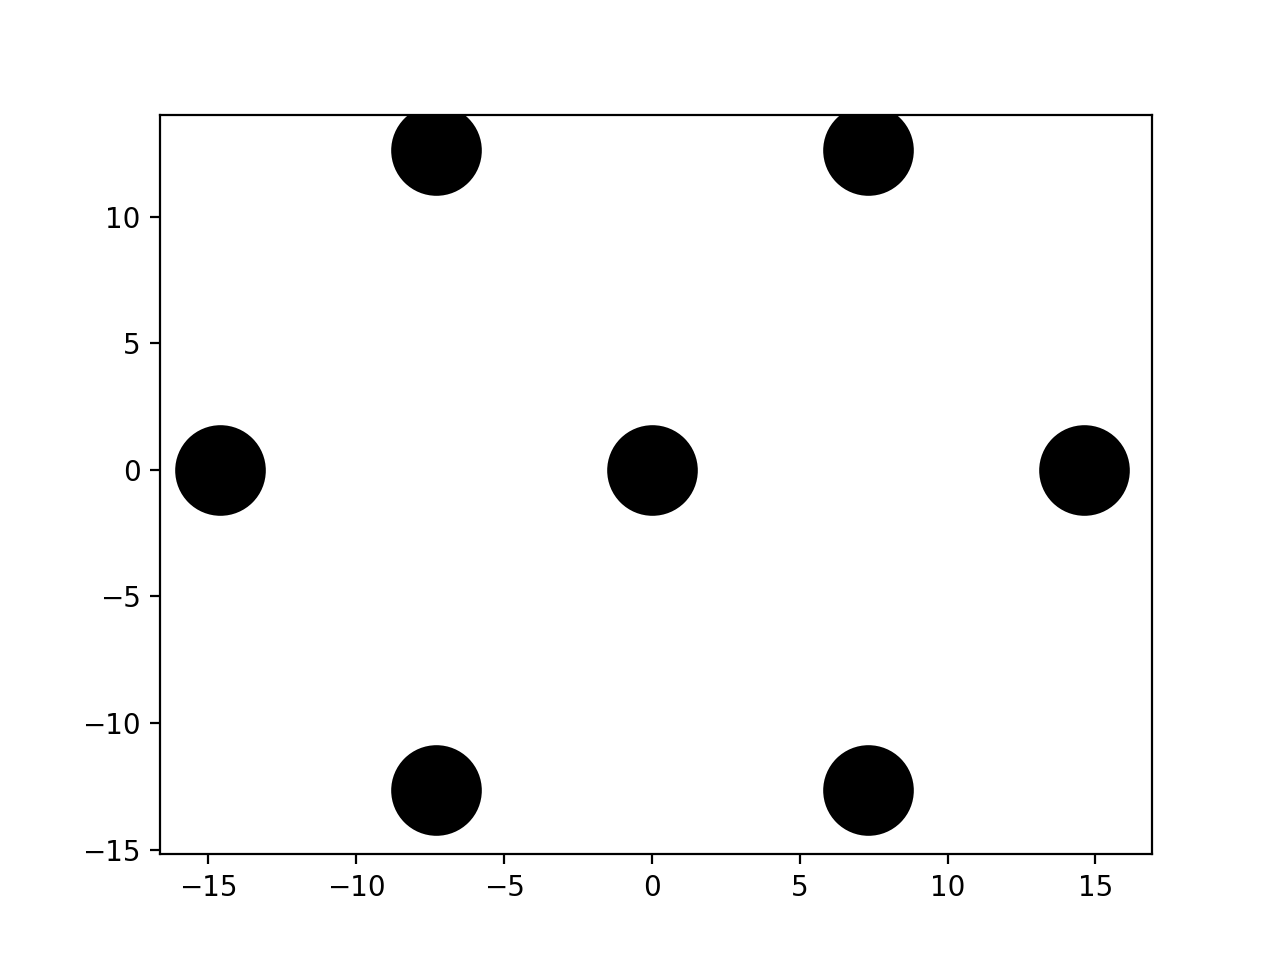

In [6]:
plt.figure()
for ant, pos in hex_arr.items():
    plt.scatter(pos[0], pos[1], color='k', s=1000)

# Bring in GLEAM data

In [7]:
hdul = fits.open("/Users/maxlee/Desktop/Research/ULAB/GLEAM_EGC_v2.fits")
frame = pd.DataFrame(hdul[1].data)

In [22]:
#Set the times and frequencies for the project
time=np.linspace(0,2*np.pi, 500)
freqs=np.linspace(140, 160, 20)

#Find the flux, ra, and dec
c_flux, c_ra, c_dec = ggf(frame, freqs,time, 500)

In [23]:
#Make the catalog object for gleam
c = cat('GLEAM', c_ra, c_dec, c_flux, time, freqs)

# Calculate the visibility

In [24]:
def visibility(flux,beam,phase):
    return np.einsum('ji,ikj->kj',flux,beam*phase)

def run(ants,catalog):
    bls = {}
    beams = {}
    vis = {}
    flux = catalog.flux
    for i, ant_i in tqd(ants.items(), leave=False, desc='ant_i'):
        for j, ant_j in tqd(ants.items(), leave=False, desc='ant_j'):
            if i <= j:
                #Calculate the baseline vector
                bls[(i,j)]=np.subtract(ant_i.position,ant_j.position) #Baseline works
                
                #Calculate the beam
                beam_i = ant_i.airy_beam(catalog.s_vectors[0], catalog.s_vectors[1], catalog.freqMHz)
                beam_j = ant_j.airy_beam(catalog.s_vectors[0], catalog.s_vectors[1], catalog.freqMHz)
                beam = np.sqrt(beam_i*beam_j)
                beams[(i,j)] = beam
                
                #Calculate the phase
                phase = catalog.getPhase(bls[i,j])
                
                #Calculate the visibility
                vis[(i,j)] =visibility(flux,beam,phase)

    return bls, beams, vis

In [25]:
bls, beams, vis = run(ants,c)

/Users/maxlee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/Users/maxlee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


# Some plots

<IPython.core.display.Javascript object>


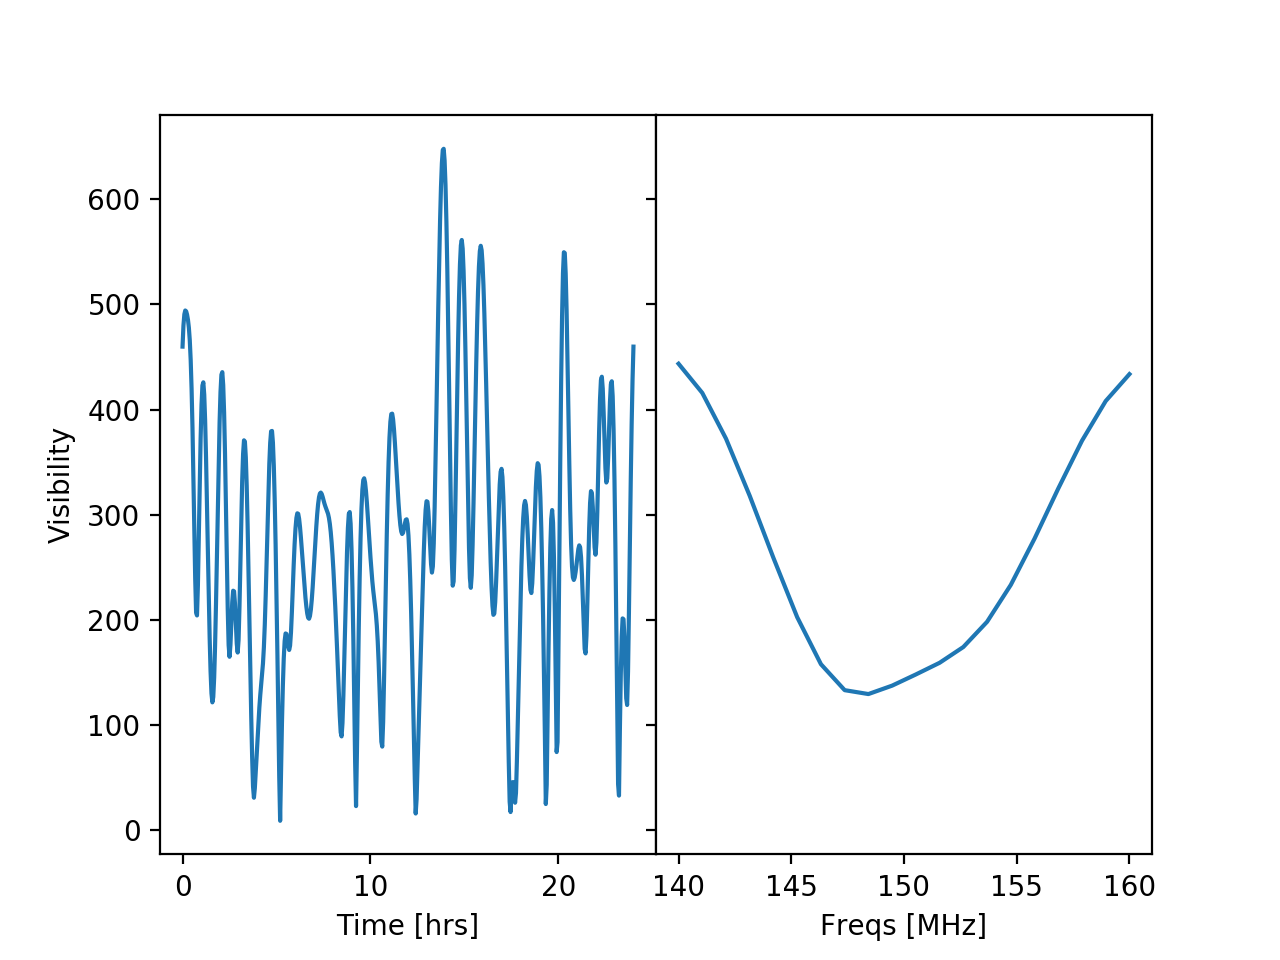

In [26]:
fig, axs = plt.subplots(ncols=2, sharey=True, gridspec_kw={'wspace':0})
axs[0].plot(time*12/np.pi, np.abs(vis[(0,1)][:,2]))
axs[0].set_xlabel('Time [hrs]')
axs[0].set_ylabel('Visibility')
axs[1].plot(freqs, np.abs(vis[(0,1)][20,:]))
axs[1].set_xlabel('Freqs [MHz]')

plt.show()

<IPython.core.display.Javascript object>


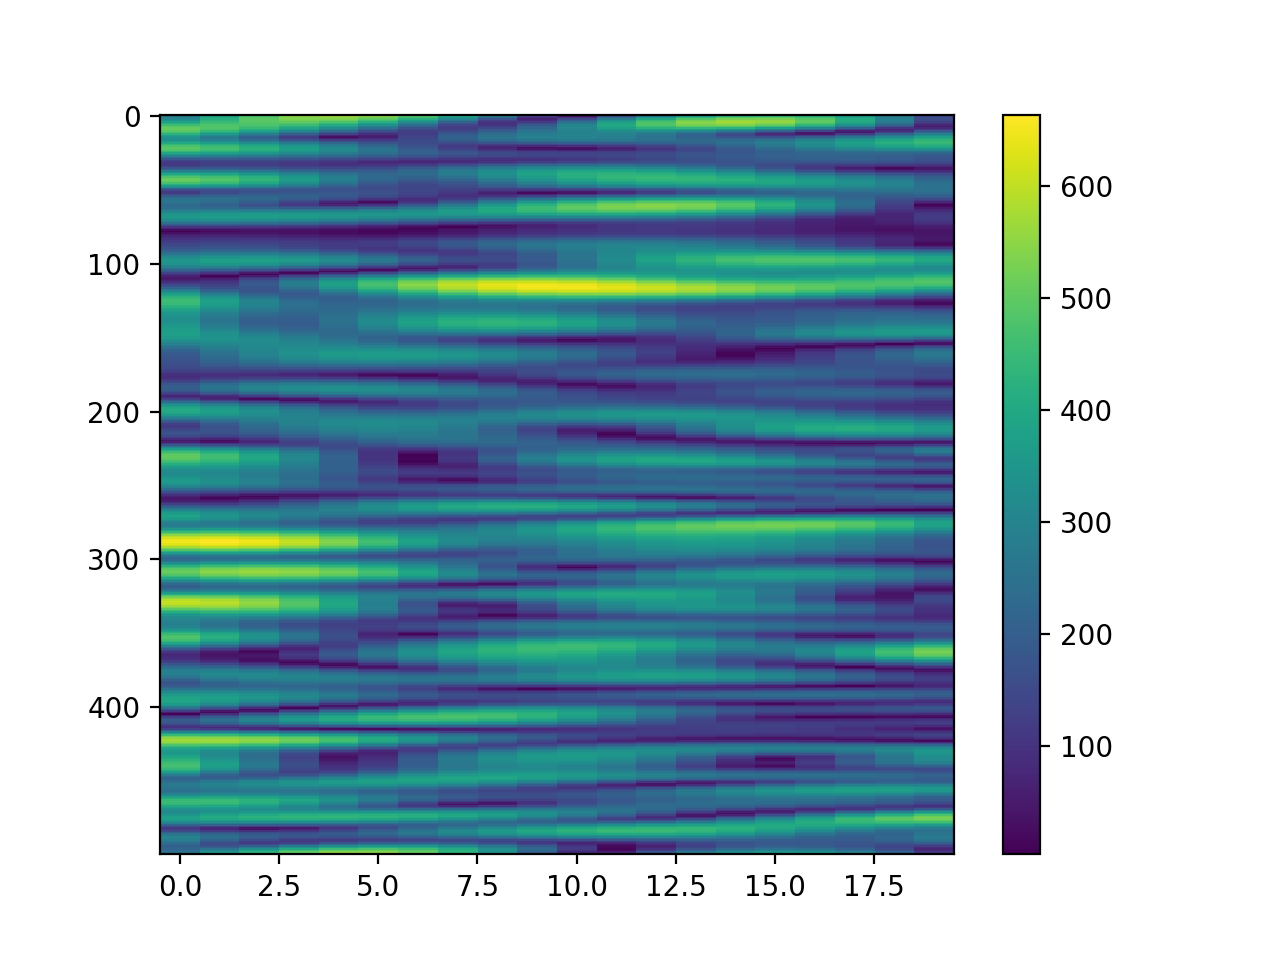

In [27]:
plt.figure()
plt.imshow(np.abs(vis[(0,1)]), aspect = 'auto')
plt.colorbar()

In [28]:
beams[(0,1)].shape

(500, 500, 20)

<IPython.core.display.Javascript object>


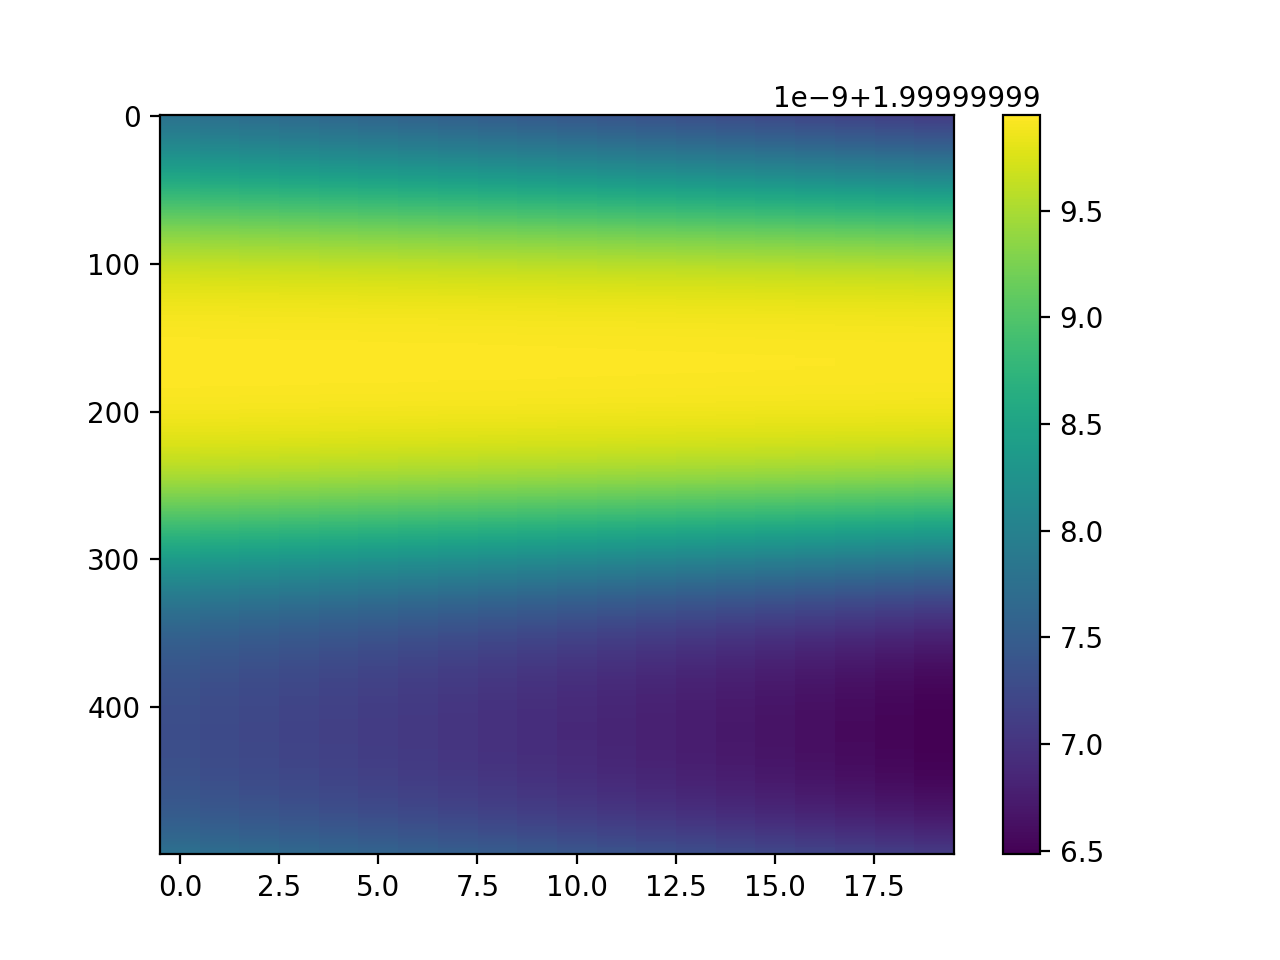

In [32]:
plt.figure()
plt.imshow(beams[(0,6)][1,:,:], aspect='auto')
plt.colorbar()

In [11]:
a = np.ones(10)
b = np.ones(9)

In [15]:
np.einsum('i,j->i', a, b)

array([9., 9., 9., 9., 9., 9., 9., 9., 9., 9.])